# INFORMACIÓN DE LAS VARIABLES

### art_sim.csv 

1. __patient__: paciente

2. __site__: lugar de donde viene

3. __art_id__: tratamiento que sigue

4. __art_sd__: fecha de inicio de tratamiento

5. __art_ed__: fecha de termino del tratamiento  - si no hay fecha de termino el paciente continuo con dicho tratamiento 

6. __art_rs__: razon de cambio de tratamiento 


### basic_sim.csv

1. __baseline_d__: fecha de enrrolamiento del paciente

2. __male__: 1 si es hombre, 0 si es mujer

3. __age__: edad del paciente 

4. __birth_d__: fecha de nacimiento 

5. __hivdiagnosis_d__: fecha de diagnostico

6. __mode__: modo de transmision de la enfermedad

7. __birth_d_a__: exactitud de la fecha registrada


### follow_sim.csv

1. __l_alive_d__: ultima fecha en la que sabemos que el paciente aun se encuentra vivo, en contacto con el sistema 

2. __death_y__: registro de su muerte, 1 si murio 0 si no murio

3. __death_d__: fecha de muerte 


### lab_cd4_sim.csv

1. __cd4_d__: fecha en la que se realizo el conteo de cd4

2. __cd4_v__: valor de cd4 correspondiente a su fecha en la que se realizo el conteo

### lab_rna_sim.csv

1. __rna_d__: fecha del conteo de la carga viral

2. __rna_v__: valor de rna correspondiente a su fecha en la que se realizo el conteo si nos marca un rna_v = -40 nos informa que en ese momento era indectable

### visit_sim.csv

1. __visit_d__: fechas de visita del paciente 


### CD4 Y RNA

__NOTA__: Lo normal es que existan entre 500 y 1600 celulas CD4 por milimetro cubico de sangre rna es el numero de copias del virus por ml de sangre o por c/ml


# PAQUETES

In [142]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None 
plt.rcParams["figure.figsize"] = (15,12)
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 50)

# CONJUNTOS DE DATOS

In [2]:
art_sim = pd.read_csv("art_sim.csv", usecols= ["patient","site","art_id","art_sd","art_ed"], parse_dates = [3,4])
basic_sim = pd.read_csv("basic_sim.csv", usecols = ["patient","baseline_d","male","age","birth_d","hivdiagnosis_d","mode","birth_d_a"])
follow_sim = pd.read_csv("follow_sim.csv", usecols = ["patient","l_alive_d","death_y","death_d"])
lab_cd4_sim = pd.read_csv("lab_cd4_sim.csv", usecols = ["patient","cd4_d","cd4_v","time"])
lab_rna_sim = pd.read_csv("lab_rna_sim.csv", usecols = ["patient","rna_d","rna_v"], parse_dates = [1])
visit_sim = pd.read_csv("visit_sim.csv", usecols = ["patient","visit_d"])

# TABLAS CON FECHAS A FILTRAR

## art_sim

Necesita modificaciones: 

1. Eliminar réplicas y dejar la primera fecha de cada una con respecto a `art_sd`

2. Eliminar réplicas y dejar la última fecha de cada una con respecto a `art_sd`

### Primeras fechas

In [3]:
art_primeros = art_sim.sort_values(by = ["patient","art_sd"]).drop_duplicates(subset = ["patient"],keep = "first")

In [4]:
art_primeros.head(2)

,patient,site,art_id,art_sd,art_ed
0,ar.1,argentina,"3TC,AZT,NVP",2007-05-16,2007-05-28
3,ar.10,argentina,"3TC,AZT,EFV",2002-02-07,NaT


### Últimas fechas

In [5]:
art_ultimos = art_sim.sort_values(by = ["patient","art_sd"], ascending= False).drop_duplicates(subset = ["patient"],keep = "first").sort_values(by = "patient")

In [6]:
art_ultimos.head(2)

,patient,site,art_id,art_sd,art_ed
2,ar.1,argentina,"3TC,ABC,AZT",2007-08-03,NaT
3,ar.10,argentina,"3TC,AZT,EFV",2002-02-07,NaT


## lab_cd4_sim

Necesita modificaciones:

1. Filtrar por `time` == 0 para posteriormente borrar esa columna

In [7]:
lab_cd4 = lab_cd4_sim[lab_cd4_sim.time == 0].drop(columns = "time")

In [8]:
lab_cd4.head(2)

,patient,cd4_d,cd4_v
0,ar.1,19/01/2007,405
6,ar.10,30/09/2002,23


## lab_rna_sim

Necesita modificaciones: 

1. Filtrar por `rna_d` las primeras fechas de cada réplica.

In [9]:
lab_rna = lab_rna_sim.sort_values(by = ["patient","rna_d"]).drop_duplicates(subset = ["patient"],keep = "first")

In [10]:
lab_rna.head(2)

,patient,rna_d,rna_v
0,ar.1,2007-01-19,74724.0
20,ar.10,2002-09-30,-50.0


# JOINTS

### Primeras fechas art

In [11]:
primeros_basic_follow = pd.merge(left = basic_sim, right = follow_sim, on = "patient", how = "outer")
primeros_basic_follow_visit =  pd.merge(left = primeros_basic_follow, right = visit_sim, on = "patient", how = "outer")
primeros_basic_follow_visit_rna = pd.merge(left = primeros_basic_follow_visit, right = lab_rna, on = "patient", how = "outer")
primeros_basic_follow_visit_rna_cd4 = pd.merge(left = primeros_basic_follow_visit_rna , right = lab_cd4, on = "patient", how = "outer")
primeros_basic_follow_visit_rna_cd4_art = pd.merge(left = primeros_basic_follow_visit_rna_cd4 , right = art_primeros, on = "patient", how = "outer")

In [12]:
primeros_basic_follow_visit_rna_cd4_art.head(5)

,patient,baseline_d,male,age,birth_d,hivdiagnosis_d,mode,birth_d_a,l_alive_d,death_y,death_d,visit_d,rna_d,rna_v,cd4_d,cd4_v,site,art_id,art_sd,art_ed
0,ar.1,2007-04-13,1,34.163291,1973-02-12,2007-04-13,Homosexual contact,D,2013-02-04,0,NaN,2007-04-13,2007-01-19,74724.0,19/01/2007,405.0,argentina,"3TC,AZT,NVP",2007-05-16,2007-05-28
1,ar.2,2010-07-06,0,45.893587,1964-08-13,1999-01-07,Injecting drug user,D,2012-09-08,0,NaN,2010-07-06,2010-05-08,-80.0,12/02/2010,30.0,argentina,"3TC,ABC,EFV",2009-10-11,2009-11-03
2,ar.3,2011-03-28,1,47.234211,1964-01-02,1999-08-13,Heterosexual contact,D,2013-08-11,0,NaN,2011-03-28,2012-04-15,40.0,15/04/2012,18.0,argentina,"D4T,DDI,NVP",2009-06-10,2009-07-09
3,ar.4,2002-04-19,0,31.469044,1970-10-30,1996-09-14,Unknown,D,2013-08-09,0,NaN,2002-04-19,2002-06-18,3112.0,18/06/2002,309.0,argentina,"3TC,ABC,EFV",2003-04-05,NaT
4,ar.5,2004-12-27,1,36.886134,1968-02-07,2002-10-23,Transfusion nonhemophilia related,D,2013-04-28,0,NaN,2004-12-27,2005-12-19,40.0,19/12/2005,305.0,argentina,"3TC,AZT,NVP",2004-09-13,2007-11-20


In [13]:
# primeros_basic_follow_visit_rna_cd4_art.to_csv("junto_primeros_crudo.csv")

### Últimas fechas art

In [14]:
ultimos_basic_follow = pd.merge(left = basic_sim, right = follow_sim, on = "patient", how = "outer")
ultimos_basic_follow_visit =  pd.merge(left = ultimos_basic_follow, right = visit_sim, on = "patient", how = "outer")
ultimos_basic_follow_visit_rna = pd.merge(left = ultimos_basic_follow_visit, right = lab_rna, on = "patient", how = "outer")
ultimos_basic_follow_visit_rna_cd4 = pd.merge(left = ultimos_basic_follow_visit_rna , right = lab_cd4, on = "patient", how = "outer")
ultimos_basic_follow_visit_rna_cd4_art = pd.merge(left = ultimos_basic_follow_visit_rna_cd4 , right = art_ultimos, on = "patient", how = "outer")

In [15]:
ultimos_basic_follow_visit_rna_cd4_art.head(5)

,patient,baseline_d,male,age,birth_d,hivdiagnosis_d,mode,birth_d_a,l_alive_d,death_y,death_d,visit_d,rna_d,rna_v,cd4_d,cd4_v,site,art_id,art_sd,art_ed
0,ar.1,2007-04-13,1,34.163291,1973-02-12,2007-04-13,Homosexual contact,D,2013-02-04,0,NaN,2007-04-13,2007-01-19,74724.0,19/01/2007,405.0,argentina,"3TC,ABC,AZT",2007-08-03,NaT
1,ar.2,2010-07-06,0,45.893587,1964-08-13,1999-01-07,Injecting drug user,D,2012-09-08,0,NaN,2010-07-06,2010-05-08,-80.0,12/02/2010,30.0,argentina,"3TC,ABC,ATV",2009-11-04,NaT
2,ar.3,2011-03-28,1,47.234211,1964-01-02,1999-08-13,Heterosexual contact,D,2013-08-11,0,NaN,2011-03-28,2012-04-15,40.0,15/04/2012,18.0,argentina,"3TC,AZT,RTV,SQV",2013-02-09,2013-08-11
3,ar.4,2002-04-19,0,31.469044,1970-10-30,1996-09-14,Unknown,D,2013-08-09,0,NaN,2002-04-19,2002-06-18,3112.0,18/06/2002,309.0,argentina,"3TC,ABC,EFV",2003-04-05,NaT
4,ar.5,2004-12-27,1,36.886134,1968-02-07,2002-10-23,Transfusion nonhemophilia related,D,2013-04-28,0,NaN,2004-12-27,2005-12-19,40.0,19/12/2005,305.0,argentina,"3TC,LPV,RTV,TDF",2007-11-20,NaT


In [16]:
# ultimos_basic_follow_visit_rna_cd4_art.to_csv("junto_ultimos_crudo.csv")

# ARREGLO SITE PARA DATOS QUE NO TUVIERON PAR EN PATIENT

El último conjunto que se pego a los demas fue ar_primeros y art_segundos. Por lo tanto, aquellos que no tuvieron par en `patient` tuvieron NaN en site y esto provocará perder información a la hora de agrupar por paises. Por fortuna, a partir de `patient` puedo encontrar el país de origen.

In [17]:
primeros_basic_follow_visit_rna_cd4_art.site.unique()

array(['argentina', nan, 'brazil', 'chile', 'haiti', 'honduras', 'mexico',
       'peru'], dtype=object)

In [18]:
def pais(x):
    if x == "ar":
        return "argentina"
    if x == "br":
        return "brazil"
    if x == "ch":
        return "chile"
    if x == "ha":
        return "haiti"
    if x == "ho":
        return "honduras"
    if x == "me":
        return "mexico"
    if x == "pe":
        return "peru"

### Primeras fechas art

In [19]:
primeros_basic_follow_visit_rna_cd4_art["site"] = primeros_basic_follow_visit_rna_cd4_art.patient.apply(lambda x: pais(x[0:2]))

### Últimas fechas art

In [20]:
ultimos_basic_follow_visit_rna_cd4_art["site"] = ultimos_basic_follow_visit_rna_cd4_art.patient.apply(lambda x: pais(x[0:2]))

# PAÍSES CON MENOS NANS

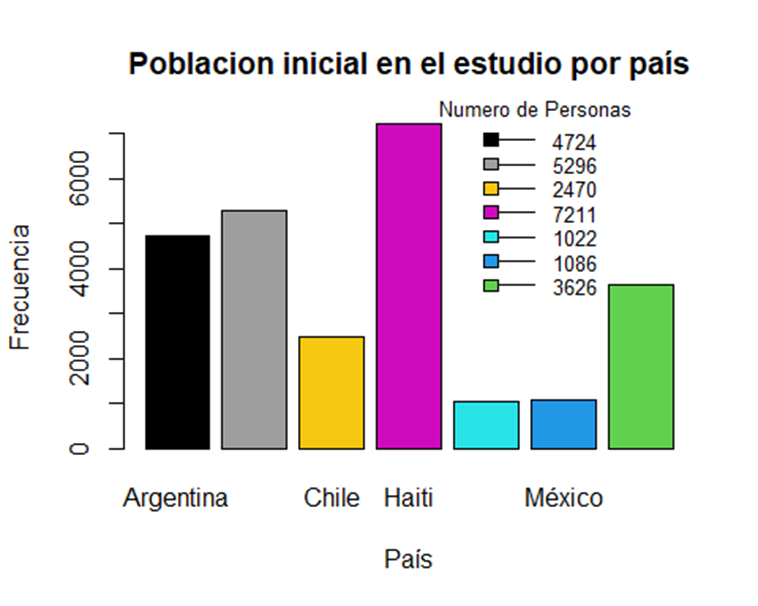

### Primeras fechas art

In [21]:
primeros_basic_follow_visit_rna_cd4_art.groupby("site")[primeros_basic_follow_visit_rna_cd4_art.drop(columns = "site").columns].count()

,patient,baseline_d,male,age,birth_d,hivdiagnosis_d,mode,birth_d_a,l_alive_d,death_y,death_d,visit_d,rna_d,rna_v,cd4_d,cd4_v,art_id,art_sd,art_ed
site,,,,,,,,,,,,,,,,,,,
argentina,4724,4724,4724,4724,4724,4724,4724,4724,4724,4724,55,4724,4119,4117,4119,4119,4720,4720,2963
brazil,5296,5296,5296,5296,5296,5296,5296,5296,5296,5296,809,5296,4432,4343,4432,4432,4930,4930,3281
chile,2470,2470,2470,2470,2470,2470,2470,2470,2470,2470,86,2470,2164,2147,2164,2164,2433,2433,1273
haiti,7211,7211,7211,7211,7211,7211,7211,7211,7211,7211,337,7211,0,0,7106,7106,7129,7129,3398
honduras,1022,1022,1022,1022,1022,1022,1022,1022,1022,1022,66,1022,974,961,974,974,1004,1004,487
mexico,1086,1086,1086,1086,1086,1086,1086,1086,1086,1086,66,1086,1069,1053,1069,1069,1066,1066,688
peru,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,224,3626,3545,3486,3545,3545,3530,3530,1770


In [22]:
for pais in primeros_basic_follow_visit_rna_cd4_art.site.unique():
    print(pais)
    print("------------------------".center(20))
    print(round(primeros_basic_follow_visit_rna_cd4_art[primeros_basic_follow_visit_rna_cd4_art.site == pais].isna().sum()/primeros_basic_follow_visit_rna_cd4_art[primeros_basic_follow_visit_rna_cd4_art.site == pais].shape[0],2)*100)
    print(2*"\n")

argentina
------------------------
patient            0.0
baseline_d         0.0
male               0.0
age                0.0
birth_d            0.0
hivdiagnosis_d     0.0
mode               0.0
birth_d_a          0.0
l_alive_d          0.0
death_y            0.0
death_d           99.0
visit_d            0.0
rna_d             13.0
rna_v             13.0
cd4_d             13.0
cd4_v             13.0
site               0.0
art_id             0.0
art_sd             0.0
art_ed            37.0
dtype: float64



brazil
------------------------
patient            0.0
baseline_d         0.0
male               0.0
age                0.0
birth_d            0.0
hivdiagnosis_d     0.0
mode               0.0
birth_d_a          0.0
l_alive_d          0.0
death_y            0.0
death_d           85.0
visit_d            0.0
rna_d             16.0
rna_v             18.0
cd4_d             16.0
cd4_v             16.0
site               0.0
art_id             7.0
art_sd             7.0
art_ed            

### Últimas fechas art

In [23]:
ultimos_basic_follow_visit_rna_cd4_art.groupby("site")[ultimos_basic_follow_visit_rna_cd4_art.drop(columns = "site").columns].count()

,patient,baseline_d,male,age,birth_d,hivdiagnosis_d,mode,birth_d_a,l_alive_d,death_y,death_d,visit_d,rna_d,rna_v,cd4_d,cd4_v,art_id,art_sd,art_ed
site,,,,,,,,,,,,,,,,,,,
argentina,4724,4724,4724,4724,4724,4724,4724,4724,4724,4724,55,4724,4119,4117,4119,4119,4720,4720,1779
brazil,5296,5296,5296,5296,5296,5296,5296,5296,5296,5296,809,5296,4432,4343,4432,4432,4930,4930,2372
chile,2470,2470,2470,2470,2470,2470,2470,2470,2470,2470,86,2470,2164,2147,2164,2164,2433,2433,776
haiti,7211,7211,7211,7211,7211,7211,7211,7211,7211,7211,337,7211,0,0,7106,7106,7129,7129,1687
honduras,1022,1022,1022,1022,1022,1022,1022,1022,1022,1022,66,1022,974,961,974,974,1004,1004,262
mexico,1086,1086,1086,1086,1086,1086,1086,1086,1086,1086,66,1086,1069,1053,1069,1069,1066,1066,322
peru,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,224,3626,3545,3486,3545,3545,3530,3530,1148


In [24]:
for pais in ultimos_basic_follow_visit_rna_cd4_art.site.unique():
    print(pais)
    print("------------------------".center(20))
    print(round(ultimos_basic_follow_visit_rna_cd4_art[ultimos_basic_follow_visit_rna_cd4_art.site == pais].isna().sum()/ultimos_basic_follow_visit_rna_cd4_art[ultimos_basic_follow_visit_rna_cd4_art.site == pais].shape[0],2)*100)
    print(2*"\n")

argentina
------------------------
patient            0.0
baseline_d         0.0
male               0.0
age                0.0
birth_d            0.0
hivdiagnosis_d     0.0
mode               0.0
birth_d_a          0.0
l_alive_d          0.0
death_y            0.0
death_d           99.0
visit_d            0.0
rna_d             13.0
rna_v             13.0
cd4_d             13.0
cd4_v             13.0
site               0.0
art_id             0.0
art_sd             0.0
art_ed            62.0
dtype: float64



brazil
------------------------
patient            0.0
baseline_d         0.0
male               0.0
age                0.0
birth_d            0.0
hivdiagnosis_d     0.0
mode               0.0
birth_d_a          0.0
l_alive_d          0.0
death_y            0.0
death_d           85.0
visit_d            0.0
rna_d             16.0
rna_v             18.0
cd4_d             16.0
cd4_v             16.0
site               0.0
art_id             7.0
art_sd             7.0
art_ed            

# BORRAR HAITI

Se decidió borrar Haiti por falta de datos en `rna_d` y `rna_v`.

### Primeras fechas art

In [25]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti = primeros_basic_follow_visit_rna_cd4_art[~ (primeros_basic_follow_visit_rna_cd4_art.site == "haiti")]

### Últimas fechas art

In [26]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti = ultimos_basic_follow_visit_rna_cd4_art[~ (ultimos_basic_follow_visit_rna_cd4_art.site == "haiti")]

# TIEMPO DE ESTUDIO

Se tomarán en cuenta solo aquellos individuos que cumplan la condición `baseline_d` >= 2000

### Primeras fechas art

In [27]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti["baseline_d"] = pd.to_datetime(primeros_basic_follow_visit_rna_cd4_art_nohaiti["baseline_d"]) 

In [28]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000 = primeros_basic_follow_visit_rna_cd4_art_nohaiti[primeros_basic_follow_visit_rna_cd4_art_nohaiti.baseline_d >= "2000"]

### Últimas fechas art

In [29]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti["baseline_d"] = pd.to_datetime(ultimos_basic_follow_visit_rna_cd4_art_nohaiti["baseline_d"]) 

In [30]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000 = ultimos_basic_follow_visit_rna_cd4_art_nohaiti[ultimos_basic_follow_visit_rna_cd4_art_nohaiti.baseline_d >= "2000"]

# TIEMPO DE SUPERVIVENCIA

#### Muertos No

`death_y` == 0 => `l_alive_d` - `baseline_d`

#### Muertos Sí

`death_y` == 1 => `death_d` - `baseline_d` 

__NOTA__: Cuando `death_` == 1, `l_alive_d` contiene la misma fechas que `death_d`. Por lo tanto, no se necesita efectuar la operación para Muertos Sí.

### Primeras fechas art

In [31]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["l_alive_d"] = pd.to_datetime(primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.l_alive_d)

primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["death_d"] = pd.to_datetime(primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.death_d)

In [32]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["supvi_dias"] = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.l_alive_d - primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.baseline_d

Eliminar `death_d` y `l_alive_d`

In [33]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.drop(columns = ["death_d","l_alive_d"], inplace = True)

Quitar formato date_time a `supvi_dias`

In [34]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["supvi_dias"] = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.supvi_dias.dt.days

### Ultimas fechas art

In [35]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["l_alive_d"] = pd.to_datetime(ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.l_alive_d)

ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["death_d"] = pd.to_datetime(ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.death_d)

In [36]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["supvi_dias"] = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.l_alive_d - ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.baseline_d

Eliminar `death_d` y `l_alive_d`

In [37]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.drop(columns = ["death_d","l_alive_d"], inplace = True)

Quitar formato date_time a `supvi_dias`

In [38]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["supvi_dias"] = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.supvi_dias.dt.days

# ELIMINAR NANS DEFINITIVOS

In [39]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.dropna(subset=primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.columns.difference(['art_ed']), inplace = True)

ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.dropna(subset=ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.columns.difference(['art_ed']), inplace = True)

# TRANSFORMACIONES

### Primeras fechas art

#### age

In [40]:
def edad(x):
    if x <= 24:
        return "18 - 24 años"
    elif x <= 44:
        return "25 - 44 años"
    elif x <= 59:
        return "45 - 59 años"
    else:
        return "60 años o más"

In [41]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["Edad_grupos"] = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["age"].apply(edad)

#### rna_v

In [42]:
def rnav(x):
    if x <= 50:
        return "CV indetectable"
    elif x < 500:
        return "CV baja"
    elif x < 40000:
        return "CV media"
    else:
        return "CV alta"

In [43]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["rna_grupos"] = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["rna_v"].apply(rnav)

#### cd4_v

In [44]:
def cd4v(x):
    if x < 200:
        return "CD4 inicial < 200"
    elif x <= 350:
        return "CD4 inicial 200 - 350"
    else:
        return "CD4 inicial > 350"

In [45]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["cd4_grupos"] = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000["cd4_v"].apply(cd4v)

#### art_id (Tratamientos)

In [52]:
primeros_trat = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000[["art_id"]]



primeros_trat["NNRTI_grupo"] = primeros_trat.art_id.str.contains(r"NVP|EFV")

primeros_trat["IP_grupo"] = primeros_trat.art_id.str.contains(r"LPV|RTV|ATV|SQV|DRV")

primeros_trat["ITRAN_grupo"] = primeros_trat.art_id.str.contains(r"DLG|RAL")




def trat(row):
    if row["NNRTI_grupo"] == 1:
        return 1
    elif row["IP_grupo"] == 1:
        return 2
    elif row["ITRAN_grupo"] == 1:
        return 3
    else:
        return 0
    
    
    
primeros_trat["art_grupo"] = primeros_trat.apply(trat , axis = 1)


primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000.join(primeros_trat.drop(columns = "art_id"))

### Últimas fechas art

#### age

In [119]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["Edad_grupos"] = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["age"].apply(edad)

#### rna_v

In [121]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["rna_grupos"] = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["rna_v"].apply(rnav)

#### cd4_v

In [123]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["cd4_grupos"] = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000["cd4_v"].apply(cd4v)

#### art_id (Tratamientos)

In [125]:
ultimos_trat = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000[["art_id"]]



ultimos_trat["NNRTI_grupo"] = ultimos_trat.art_id.str.contains(r"NVP|EFV")

ultimos_trat["IP_grupo"] = ultimos_trat.art_id.str.contains(r"LPV|RTV|ATV|SQV|DRV")

ultimos_trat["ITRAN_grupo"] = ultimos_trat.art_id.str.contains(r"DLG|RAL")


        
ultimos_trat["art_grupo"] = ultimos_trat.apply(trat , axis = 1)


ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000.join(ultimos_trat.drop(columns = "art_id"))

# BASES LISTAS

In [134]:
primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones.head()

,patient,baseline_d,male,age,birth_d,hivdiagnosis_d,mode,birth_d_a,death_y,visit_d,rna_d,rna_v,cd4_d,cd4_v,site,art_id,art_sd,art_ed,supvi_dias,Edad_grupos,rna_grupos,cd4_grupos,NNRTI_grupo,IP_grupo,ITRAN_grupo,art_grupo
0,ar.1,2007-04-13,1,34.163291,1973-02-12,2007-04-13,Homosexual contact,D,0,2007-04-13,2007-01-19,74724.0,19/01/2007,405.0,argentina,"3TC,AZT,NVP",2007-05-16,2007-05-28,2124,25 - 44 años,CV alta,CD4 inicial > 350,True,False,False,1
1,ar.2,2010-07-06,0,45.893587,1964-08-13,1999-01-07,Injecting drug user,D,0,2010-07-06,2010-05-08,-80.0,12/02/2010,30.0,argentina,"3TC,ABC,EFV",2009-10-11,2009-11-03,795,45 - 59 años,CV indetectable,CD4 inicial < 200,True,False,False,1
2,ar.3,2011-03-28,1,47.234211,1964-01-02,1999-08-13,Heterosexual contact,D,0,2011-03-28,2012-04-15,40.0,15/04/2012,18.0,argentina,"D4T,DDI,NVP",2009-06-10,2009-07-09,867,45 - 59 años,CV indetectable,CD4 inicial < 200,True,False,False,1
3,ar.4,2002-04-19,0,31.469044,1970-10-30,1996-09-14,Unknown,D,0,2002-04-19,2002-06-18,3112.0,18/06/2002,309.0,argentina,"3TC,ABC,EFV",2003-04-05,NaT,4130,25 - 44 años,CV media,CD4 inicial 200 - 350,True,False,False,1
4,ar.5,2004-12-27,1,36.886134,1968-02-07,2002-10-23,Transfusion nonhemophilia related,D,0,2004-12-27,2005-12-19,40.0,19/12/2005,305.0,argentina,"3TC,AZT,NVP",2004-09-13,2007-11-20,3044,25 - 44 años,CV indetectable,CD4 inicial 200 - 350,True,False,False,1


In [135]:
ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones.head()

,patient,baseline_d,male,age,birth_d,hivdiagnosis_d,mode,birth_d_a,death_y,visit_d,rna_d,rna_v,cd4_d,cd4_v,site,art_id,art_sd,art_ed,supvi_dias,Edad_grupos,rna_grupos,cd4_grupos,NNRTI_grupo,IP_grupo,ITRAN_grupo,art_grupo
0,ar.1,2007-04-13,1,34.163291,1973-02-12,2007-04-13,Homosexual contact,D,0,2007-04-13,2007-01-19,74724.0,19/01/2007,405.0,argentina,"3TC,ABC,AZT",2007-08-03,NaT,2124,25 - 44 años,CV alta,CD4 inicial > 350,False,False,False,0
1,ar.2,2010-07-06,0,45.893587,1964-08-13,1999-01-07,Injecting drug user,D,0,2010-07-06,2010-05-08,-80.0,12/02/2010,30.0,argentina,"3TC,ABC,ATV",2009-11-04,NaT,795,45 - 59 años,CV indetectable,CD4 inicial < 200,False,True,False,2
2,ar.3,2011-03-28,1,47.234211,1964-01-02,1999-08-13,Heterosexual contact,D,0,2011-03-28,2012-04-15,40.0,15/04/2012,18.0,argentina,"3TC,AZT,RTV,SQV",2013-02-09,2013-08-11,867,45 - 59 años,CV indetectable,CD4 inicial < 200,False,True,False,2
3,ar.4,2002-04-19,0,31.469044,1970-10-30,1996-09-14,Unknown,D,0,2002-04-19,2002-06-18,3112.0,18/06/2002,309.0,argentina,"3TC,ABC,EFV",2003-04-05,NaT,4130,25 - 44 años,CV media,CD4 inicial 200 - 350,True,False,False,1
4,ar.5,2004-12-27,1,36.886134,1968-02-07,2002-10-23,Transfusion nonhemophilia related,D,0,2004-12-27,2005-12-19,40.0,19/12/2005,305.0,argentina,"3TC,LPV,RTV,TDF",2007-11-20,NaT,3044,25 - 44 años,CV indetectable,CD4 inicial 200 - 350,False,True,False,2


# CSV

In [137]:
# primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones.to_csv("primeros_final_bayesiana.csv", index = True)

# ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones.to_csv("ultimos_final_bayesiana.csv", index = True)

# ANÁLISIS DESCRIPTIVO

In [241]:
desp = primeros_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones[["mode","site","Edad_grupos","rna_grupos","cd4_grupos","art_grupo"]]

desu = ultimos_basic_follow_visit_rna_cd4_art_nohaiti_2000_transformaciones[["mode","site","Edad_grupos","rna_grupos","cd4_grupos","art_grupo"]]

### Primeras fechas art 

In [242]:
desp.replace({"argentina": "Argentina","brazil":"Brasil","peru":"Perú","chile":"Chile","mexico":"México", "honduras": "Honduras"}, inplace = True)
desp.replace({0:"NNRTF",1:"IP",2:"IRAN",3:"COMBINADO"}, inplace = True)
desp.replace({"Homosexual contact":"Contacto Homosexual","Heterosexual contact":"Contacto Heterosexual","Unknown":"Desconocido","Other (specify in mode_oth)": "Otro","Transfusion nonhemophilia related": "Relacionado a transfusión sin hemofilia","Generic Sexual":"Sexual no especificado","Heterosexual contact and Injecting drug user":"Contacto heterosexual y usuario de drogas inyectadas","Homo/Bisexual and Injecting drug user":"Homo/Bisexual y usuario de drogas inyectadas","Injecting drug user":"Usuario de drogas inyectadas","Hemophiliac":"Por hemofilia"}, inplace = True)

In [243]:
desp

,mode,site,Edad_grupos,rna_grupos,cd4_grupos,art_grupo
0,Contacto Homosexual,Argentina,25 - 44 años,CV alta,CD4 inicial > 350,IP
1,Usuario de drogas inyectadas,Argentina,45 - 59 años,CV indetectable,CD4 inicial < 200,IP
2,Contacto Heterosexual,Argentina,45 - 59 años,CV indetectable,CD4 inicial < 200,IP
3,Desconocido,Argentina,25 - 44 años,CV media,CD4 inicial 200 - 350,IP
4,Relacionado a transfusión sin hemofilia,Argentina,25 - 44 años,CV indetectable,CD4 inicial 200 - 350,IP
...,...,...,...,...,...,...
25430,Bisexual,Perú,18 - 24 años,CV baja,CD4 inicial < 200,IP
25431,Desconocido,Perú,25 - 44 años,CV alta,CD4 inicial < 200,NNRTF
25432,Desconocido,Perú,25 - 44 años,CV media,CD4 inicial < 200,IP
25433,Desconocido,Perú,60 años o más,CV alta,CD4 inicial < 200,IP


#### mode

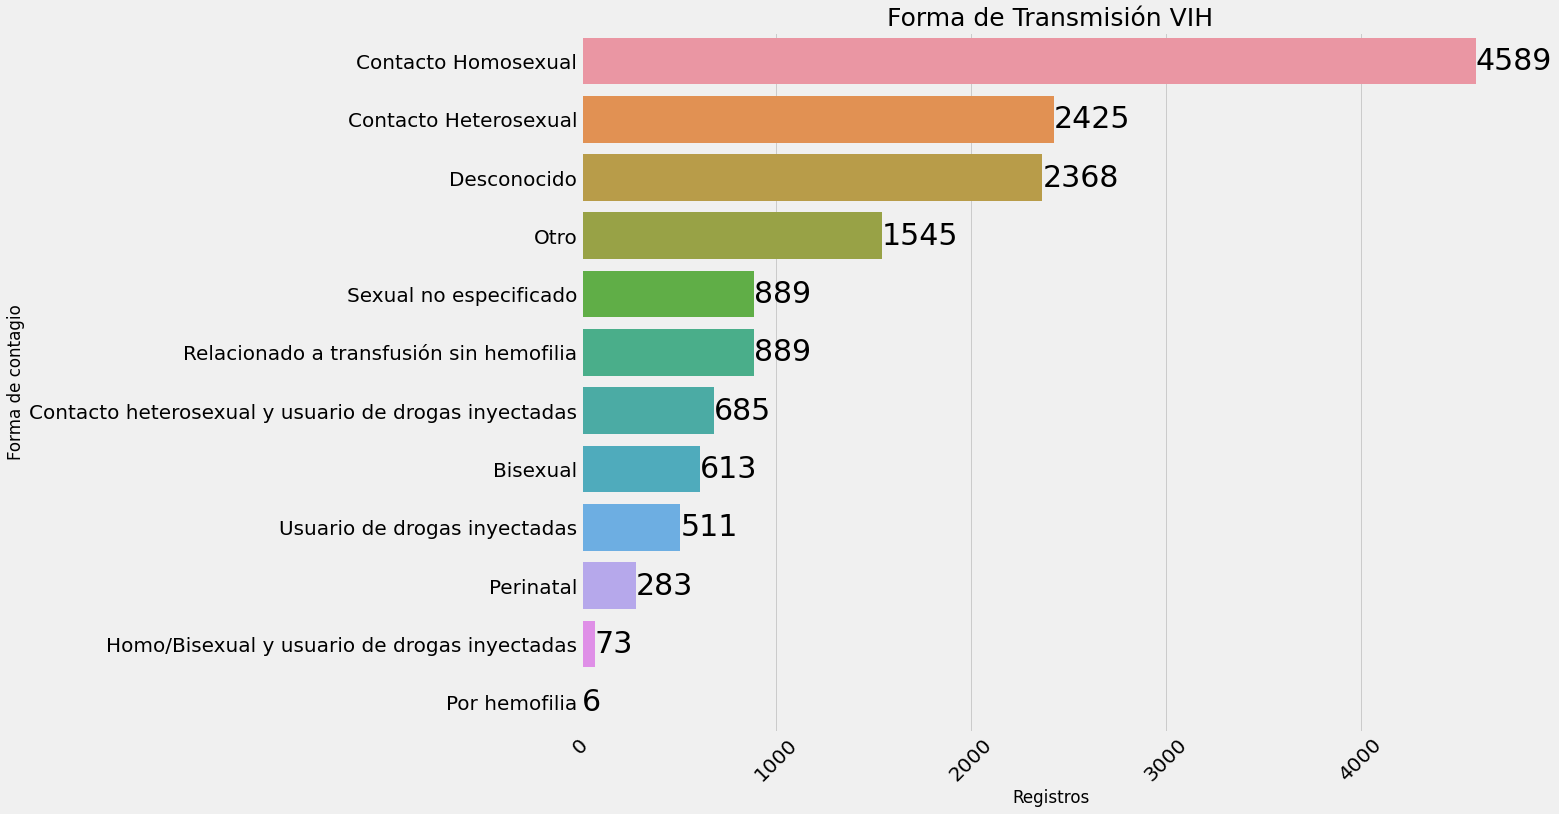

In [262]:
ax = sns.countplot(y = "mode",order = desp['mode'].value_counts().index, data = desp)
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("Forma de Transmisión VIH", fontsize = 25)
plt.ylabel("Forma de contagio")
plt.xlabel("Registros")
plt.xticks(size = 20, rotation = "45")
plt.yticks(size = 20)

# plt.savefig("Transmision_primeras",bbox_inches = "tight", pad_inches = 0)

plt.show()

### site

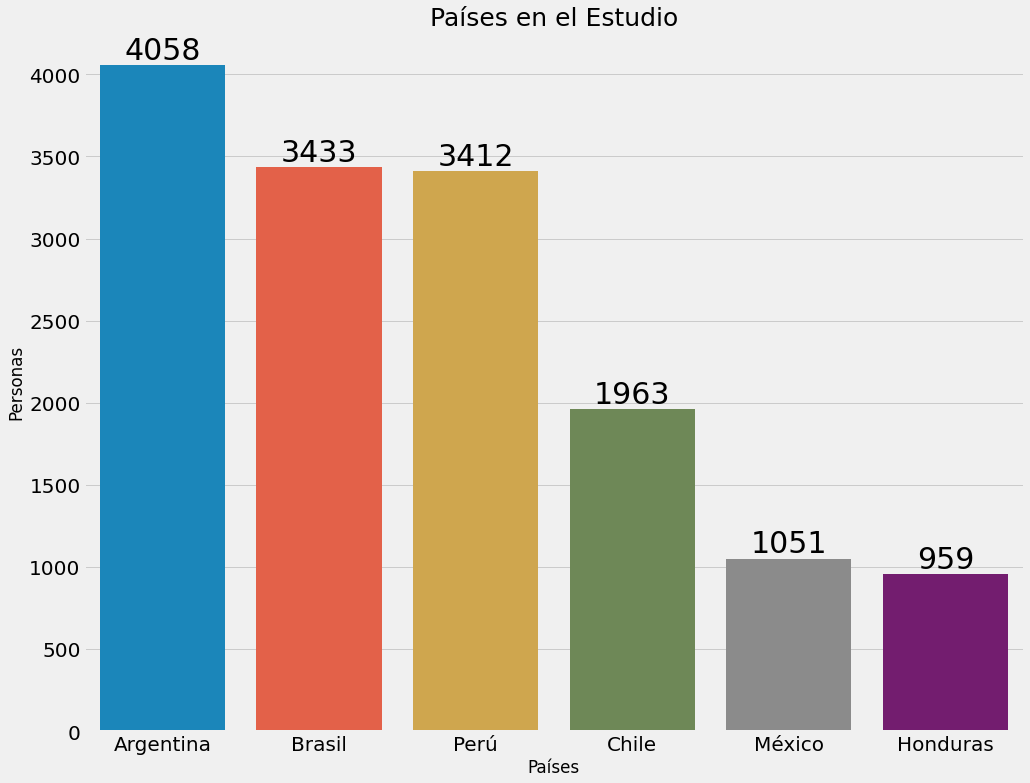

In [263]:
ax = sns.countplot(x = "site",order = desp['site'].value_counts().index, data = desp) 
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("Países en el Estudio", fontsize = 25)
plt.ylabel("Personas")
plt.xlabel("Países")
plt.xticks(size = 20)
plt.yticks(size = 20)

# plt.savefig("Paises_primeras",bbox_inches = "tight", pad_inches = 0)

plt.show()

### Edad

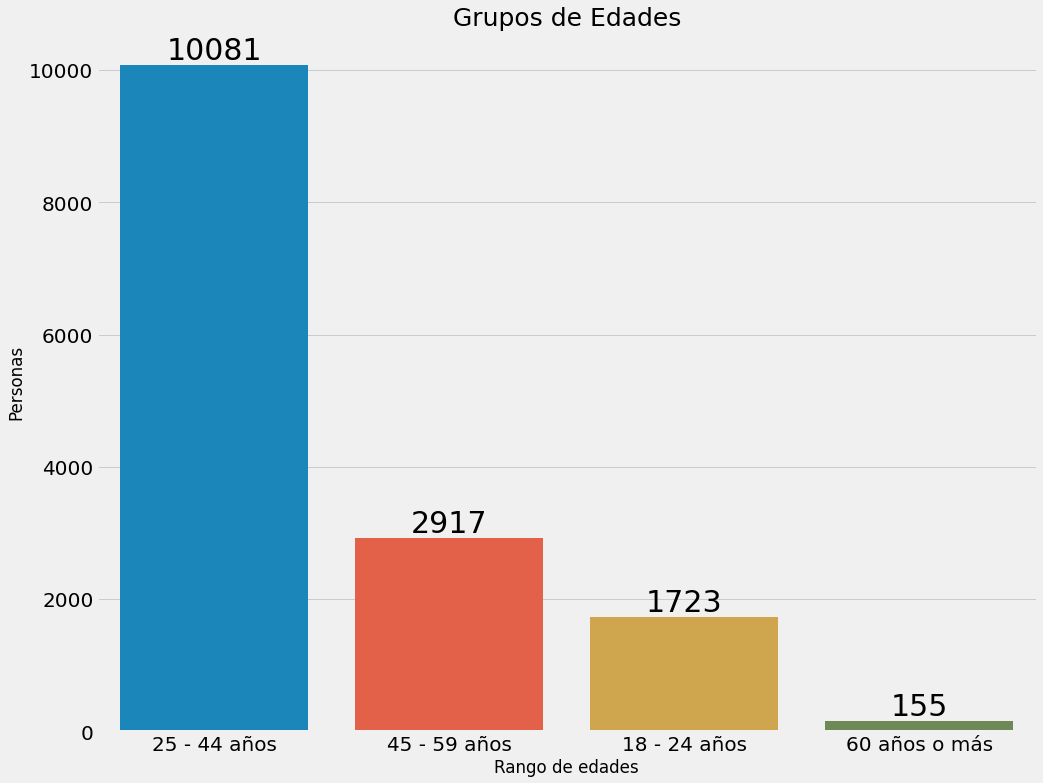

In [264]:
ax = sns.countplot(x = "Edad_grupos",order = desp['Edad_grupos'].value_counts().index, data = desp) 
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("Grupos de Edades", fontsize = 25)
plt.ylabel("Personas")
plt.xlabel("Rango de edades")
plt.xticks(size = 20)
plt.yticks(size = 20)

# plt.savefig("Edades_primeras",bbox_inches = "tight", pad_inches = 0)

plt.show()

### rna

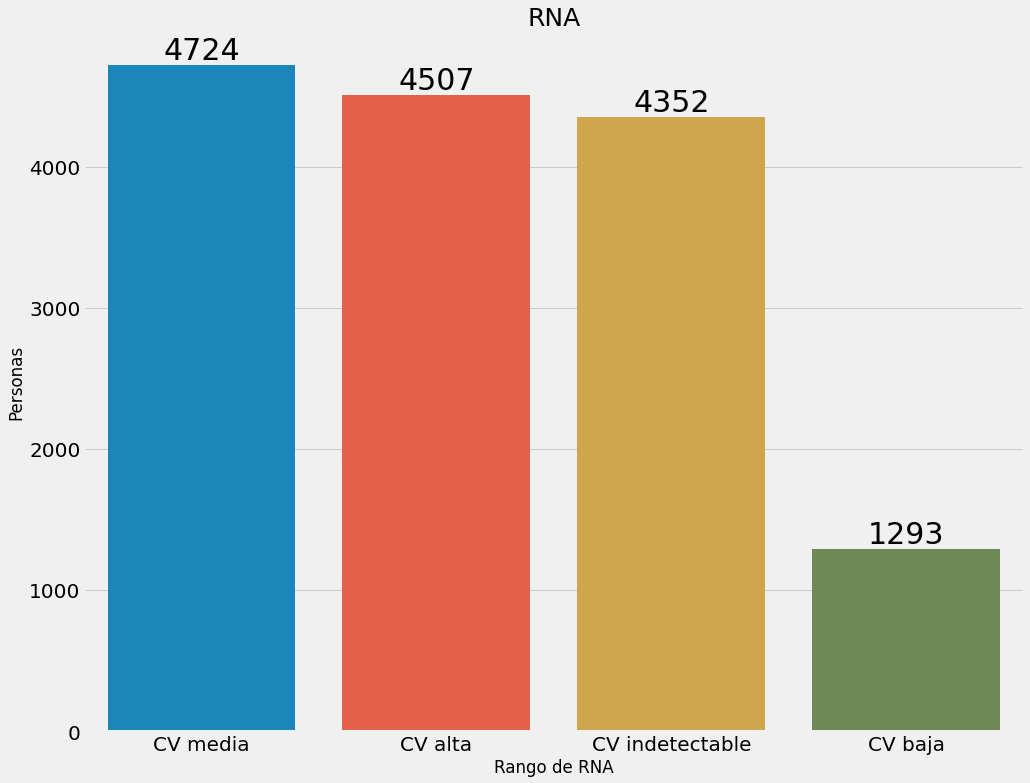

In [265]:
ax = sns.countplot(x = "rna_grupos",order = desp['rna_grupos'].value_counts().index, data = desp)
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("RNA", fontsize = 25)
plt.ylabel("Personas")
plt.xlabel("Rango de RNA")
plt.xticks(size = 20)
plt.yticks(size = 20)

# plt.savefig("RNA_primeras",bbox_inches = "tight", pad_inches = 0)

plt.show()

### cd4

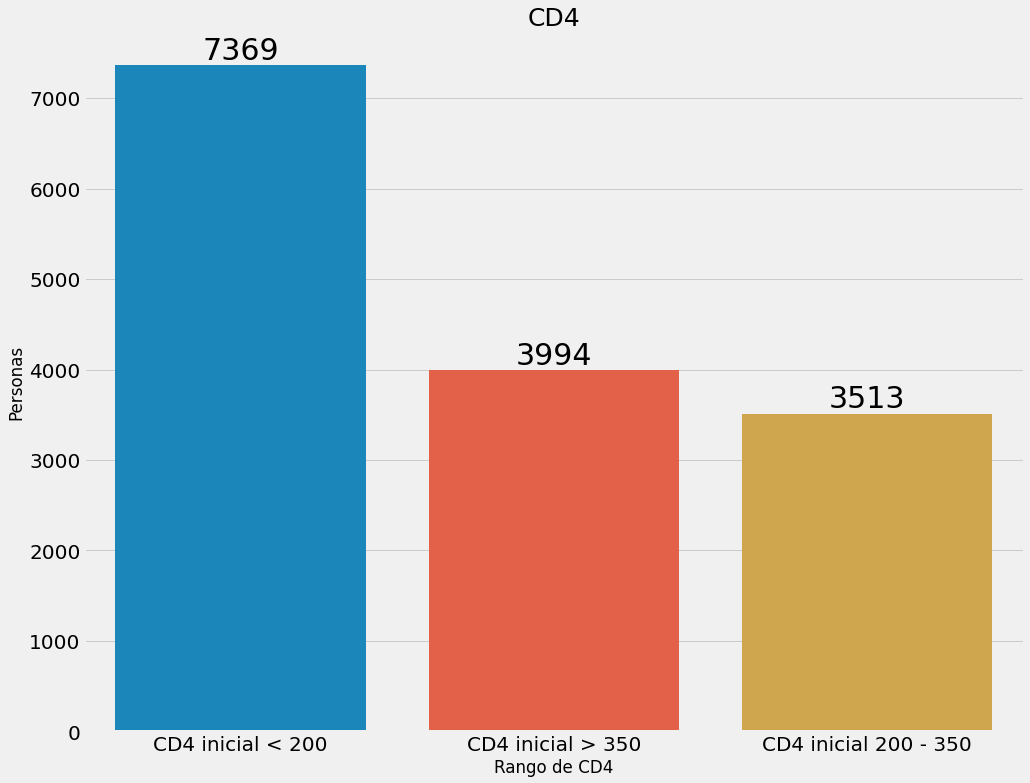

In [266]:
ax = sns.countplot(x = "cd4_grupos",order = desp['cd4_grupos'].value_counts().index, data = desp)
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("CD4", fontsize = 25)
plt.ylabel("Personas")
plt.xlabel("Rango de CD4")
plt.xticks(size = 20)
plt.yticks(size = 20)

# plt.savefig("CD4_primeras",bbox_inches = "tight", pad_inches = 0)

plt.show()

### Tratamientos

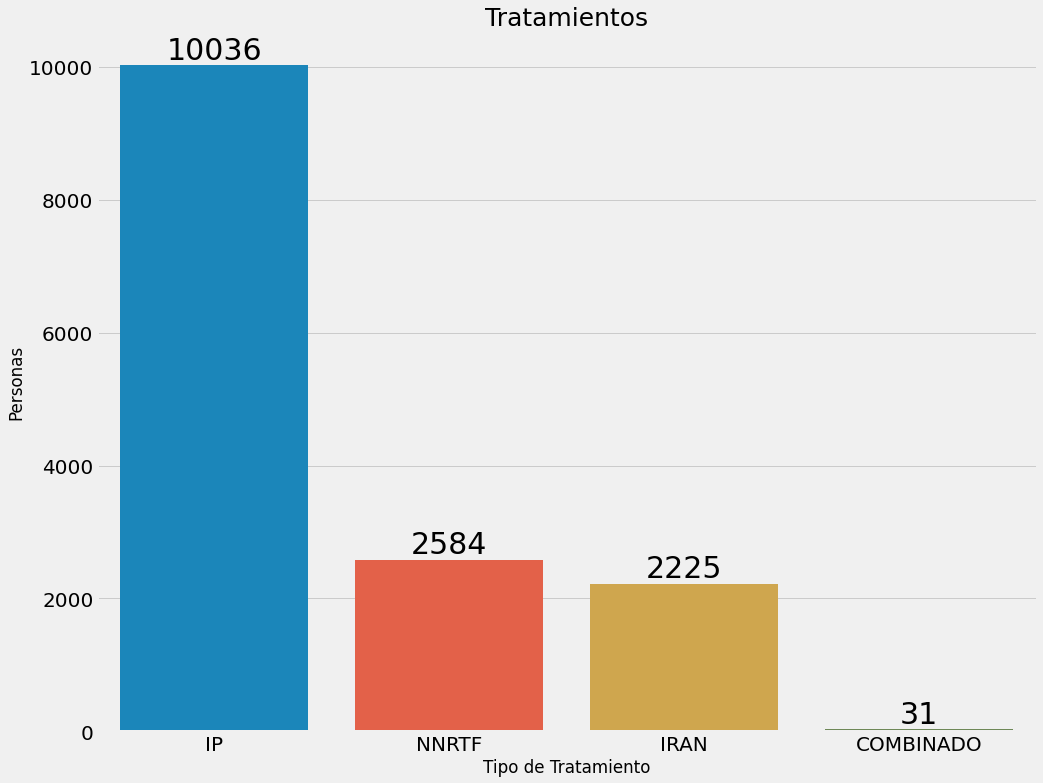

In [267]:
ax = sns.countplot(x = "art_grupo",order = desp['art_grupo'].value_counts().index, data = desp)
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("Tratamientos", fontsize = 25)
plt.ylabel("Personas")
plt.xlabel("Tipo de Tratamiento")
plt.xticks(size = 20)
plt.yticks(size = 20)

# plt.savefig("Tratamiento_primeras",bbox_inches = "tight", pad_inches = 0)

plt.show()

### Últimas fechas art

Las gráficas del primer conjunto de datos son iguales que las del segundo conjunto, excepto por la gráfica de tratamientos, pues estos pudieron haber cambiado dependiendo de la fecha. 

In [258]:
desu.replace({0:"NNRTF",1:"IP",2:"IRAN",3:"COMBINADO"}, inplace = True)

In [259]:
desu

,mode,site,Edad_grupos,rna_grupos,cd4_grupos,art_grupo
0,Contacto Homosexual,argentina,25 - 44 años,CV alta,CD4 inicial > 350,NNRTF
1,Usuario de drogas inyectadas,argentina,45 - 59 años,CV indetectable,CD4 inicial < 200,IRAN
2,Contacto Heterosexual,argentina,45 - 59 años,CV indetectable,CD4 inicial < 200,IRAN
3,Desconocido,argentina,25 - 44 años,CV media,CD4 inicial 200 - 350,IP
4,Relacionado a transfusión sin hemofilia,argentina,25 - 44 años,CV indetectable,CD4 inicial 200 - 350,IRAN
...,...,...,...,...,...,...
25430,Bisexual,peru,18 - 24 años,CV baja,CD4 inicial < 200,IP
25431,Desconocido,peru,25 - 44 años,CV alta,CD4 inicial < 200,NNRTF
25432,Desconocido,peru,25 - 44 años,CV media,CD4 inicial < 200,IP
25433,Desconocido,peru,60 años o más,CV alta,CD4 inicial < 200,IP


### Tratamientos

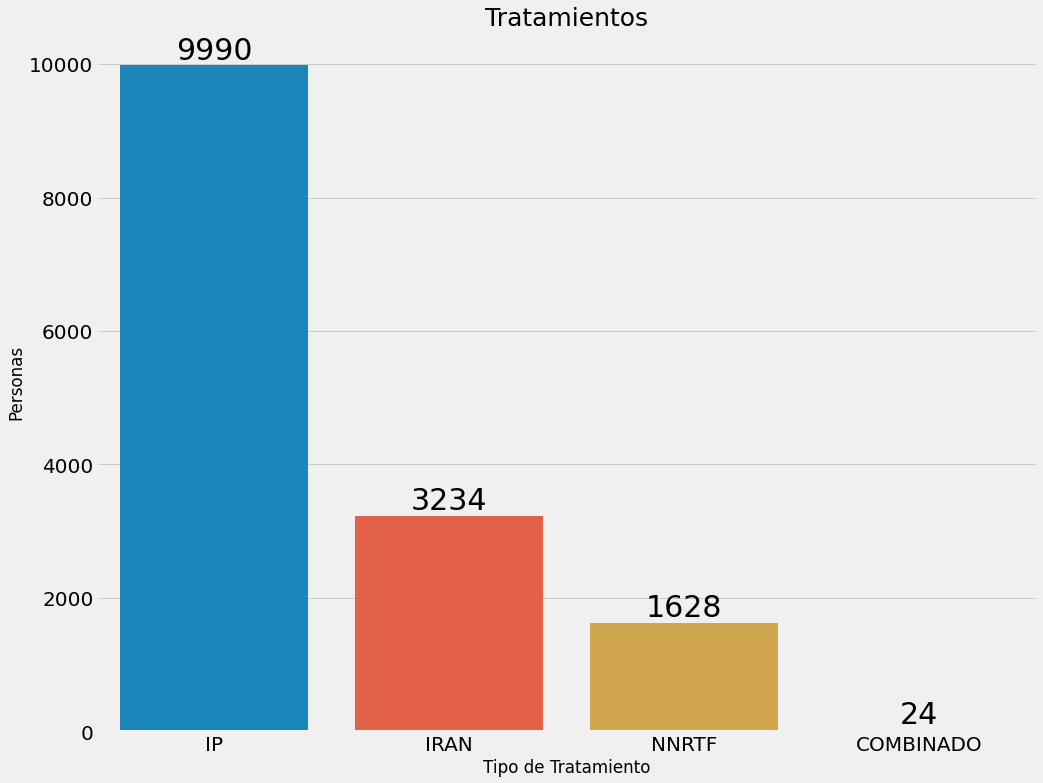

In [268]:
ax = sns.countplot(x = "art_grupo",order = desu['art_grupo'].value_counts().index, data = desu)
ax.bar_label(ax.containers[0], size = 30, label_type = "edge")
plt.title("Tratamientos", fontsize = 25)
plt.ylabel("Personas")
plt.xlabel("Tipo de Tratamiento")
plt.xticks(size = 20)
plt.yticks(size = 20)

# plt.savefig("Tratamiento_ultimas",bbox_inches = "tight", pad_inches = 0)

plt.show()